In [1]:
import os
import glob
import subprocess
import numpy as np
import pandas as pd

import sklearn.mixture
import seaborn as sns 
import matplotlib.pyplot as plt

## Load data

### GTF

In [2]:
# gtf = pd.read_csv('/node200data/18parkky/datasets/reference/transcriptome/GFF/gencode.v47.basic.annotation.labeled.gtf', sep='\t')
# dict_TranscriptID_to_GeneName   = { tup.ENST : tup.gene_name for tup in gtf.itertuples() }
# dict_TranscriptID_to_GeneID     = { tup.ENST : tup.ENSG for tup in gtf[gtf['feature']=='transcript'].itertuples() }

### Salmon

In [3]:
SGBulk_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/SG-BULK/Synapse-metadata/SG-BULK_patient_clinical_information.csv')
SGBulk_metadata_MSI = SGBulk_metadata[SGBulk_metadata['MSI.Status']=='MSI'].copy()
MSI_PatientID = list([ str(e) for e in SGBulk_metadata_MSI['patient_id'] ])

In [4]:
SalmonOut = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/SG-BULK/Synapse-metadata/SG-BULK_salmonTPM.csv')
SalmonOut.rename( {'Unnamed: 0' : 'GeneID'}, axis=1, inplace=True )

dict_GeneID_to_GeneName = { tup.ENSG.split('.')[0] : tup.gene_name for tup in gtf.itertuples() }
for ENSG in SalmonOut['GeneID']:
    try: dict_GeneID_to_GeneName[ENSG]
    except KeyError: dict_GeneID_to_GeneName[ENSG] = None
    
SalmonOut['GeneName'] = [ dict_GeneID_to_GeneName[GID] for GID in SalmonOut['GeneID'] ]

# Filter out MSS patients
SalmonOut = SalmonOut[['GeneID', 'GeneName']+ MSI_PatientID ].copy()

### NanoMnT

In [8]:
AlleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG-BULK/AlleleTable.concat.processed.tsv.gz', sep='\t', )

In [9]:
AlleleTable_MSI = AlleleTable[AlleleTable['PatientID'].isin( set(SGBulk_metadata_MSI['patient_id']) )].copy()

In [10]:
STRProfileByPatient = list()

for PatientID, edf in AlleleTable_MSI.groupby('PatientID'):
    for reference_STR_allele, edf2 in edf.groupby('reference_STR_allele'):
        STRProfileByPatient.append( [str(PatientID), 
                                     reference_STR_allele, 
                                     np.mean(edf2['diff']),
                                     np.std(edf2['diff']), 
                                     len(edf2)] )
        
STRProfileByPatient = pd.DataFrame(STRProfileByPatient, columns=['PatientID', 'reference_STR_allele', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci'])
STRProfileByPatient = STRProfileByPatient[STRProfileByPatient['NumSTRLoci']>=1000].copy()

### Tumor purity

In [36]:
TumorPurity = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG-BULK/TumorPurity.tsv', sep='\t')
dict_PatientID_to_Purity = { str(tup.id) : float(tup.purity) for tup in TumorPurity.itertuples() }
STRProfileByPatient['TumorPurity'] = [ dict_PatientID_to_Purity[PID] for PID in STRProfileByPatient['PatientID'] ]

## Gaussian Mixture Model to deconvolute Tumor vs. Normal STR profiles

In [97]:
iCMS_marker = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/iCMS_marker/iCMS_marker_genes.csv')
iCMS3_up = list(iCMS_marker['iCMS3_Up'].dropna())
iCMS3_dw = list(iCMS_marker['iCMS3_Down'].dropna())

In [100]:
AverageSTRProfileByPatient = list()

for PatientID, edf in AlleleTable_MSI[(AlleleTable_MSI['reference_STR_allele']>=12) & 
                                      (AlleleTable_MSI['reference_STR_allele']<=20)].groupby('PatientID'):

    AverageSTRProfileByPatient.append( [str(PatientID), 
                                    np.mean(edf['diff']),
                                    np.std(edf['diff']), 
                                    len(edf)] )
        
AverageSTRProfileByPatient = pd.DataFrame(AverageSTRProfileByPatient, columns=['PatientID', 'AvgSTRDiff', 'StdSTRDiff', 'NumSTRLoci'])
AverageSTRProfileByPatient['TumorPurity'] = [ dict_PatientID_to_Purity[PID] for PID in AverageSTRProfileByPatient['PatientID'] ]
AverageSTRProfileByPatient['Adjusted_AvgSTRDiff'] = [ tup.AvgSTRDiff / tup.TumorPurity for tup in AverageSTRProfileByPatient.itertuples() ]
AverageSTRProfileByPatient['Adjusted_StdSTRDiff'] = [ tup.StdSTRDiff / tup.TumorPurity for tup in AverageSTRProfileByPatient.itertuples() ]

<Axes: xlabel='Adjusted_AvgSTRDiff', ylabel='MeanExpression'>

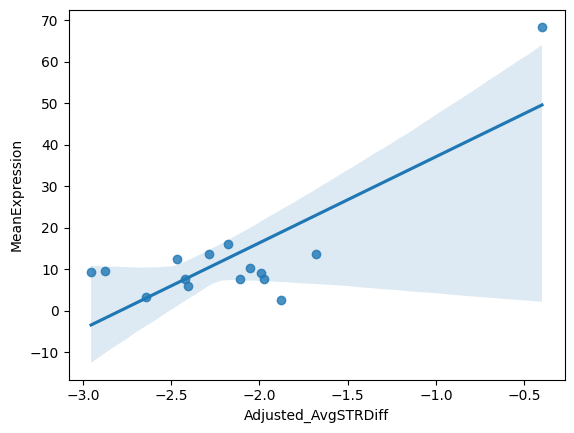

In [126]:
genesOfInterest = [ 'RGMB', 'PRUNE2' ]

dict_PatientID_to_Expression = {}

for tup in SalmonOut[SalmonOut["GeneName"].isin(genesOfInterest)].itertuples():
    for idx, elem in enumerate(tup[1:]):
        if SalmonOut.columns[idx] in ['GeneID', 'GeneName']:
            continue
        else:
            try:
                dict_PatientID_to_Expression[SalmonOut.columns[idx]].append(float(elem))
            except KeyError:
                dict_PatientID_to_Expression[SalmonOut.columns[idx]] = [float(elem)]

AverageSTRProfileByPatient['MeanExpression'] = [ np.mean(dict_PatientID_to_Expression[PID]) for PID in AverageSTRProfileByPatient['PatientID'] ]

# sns.scatterplot(data=AverageSTRProfileByPatient, x='TumorPurity', y='MeanExpression')
sns.regplot(data=AverageSTRProfileByPatient, x='Adjusted_AvgSTRDiff', y='MeanExpression')

In [86]:
dict_PatientID_to_TumorGaussianWeight = dict()

for PatientID_OfInterest in set(AlleleTable_MSI['PatientID']):

    AlleleTable_MSI_oi = AlleleTable_MSI[(AlleleTable_MSI['PatientID']==int(PatientID_OfInterest)) & 
                                         (AlleleTable_MSI['reference_STR_allele']==12)].copy()

    X = np.array(list(AlleleTable_MSI_oi['diff']))
    X = X.reshape(-1, 1)

    gm = sklearn.mixture.GaussianMixture(n_components=2, random_state=42).fit(X)
    predicted_clusters = gm.predict(X)
    predicted_clusters = [ str(e) for e in predicted_clusters ]
    AlleleTable_MSI_oi['PredictedCluster'] = predicted_clusters
    temp = dict()
    for PredictedCluster, edf in AlleleTable_MSI_oi.groupby('PredictedCluster'):
        temp[PredictedCluster] = np.mean(edf['diff'])
    temp = dict(sorted(temp.items(), key=lambda x:x[1]))
    
    for cluster, AvgDiff in temp.items():
        break 
    
    print(PatientID_OfInterest, flush=True)
    dict_PatientID_to_TumorGaussianWeight[PatientID_OfInterest] = len(AlleleTable_MSI_oi[AlleleTable_MSI_oi['PredictedCluster']==cluster])/len(AlleleTable_MSI_oi)
    

612
1253
649
490
814
1424
1105
786
1236
1556
1528
1657
698
1627
1054


In [87]:
STRProfileByPatient['TumorGaussianWeight'] = [ dict_PatientID_to_TumorGaussianWeight[int(PID)] for PID in STRProfileByPatient['PatientID'] ]

<Axes: xlabel='TumorGaussianWeight', ylabel='TumorPurity'>

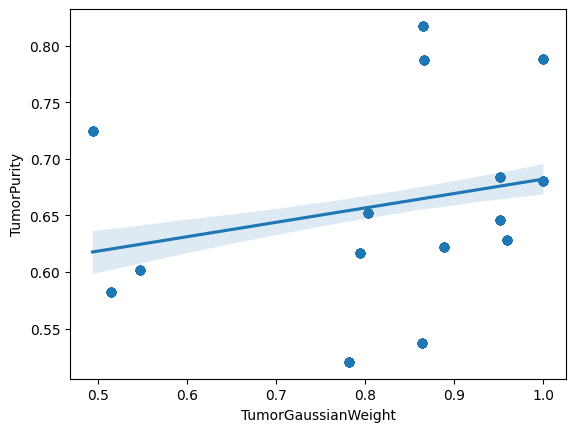

In [88]:
# sns.scatterplot(data=STRProfileByPatient, x='TumorGaussianWeight', y='TumorPurity',)
sns.regplot(data=STRProfileByPatient, x='TumorGaussianWeight', y='TumorPurity',)

In [65]:
dict_PatientID_to_Purity[PatientID_OfInterest]

0.788504471

[Text(0, 0, '24.5993'), Text(0, 0, '75.4007')]

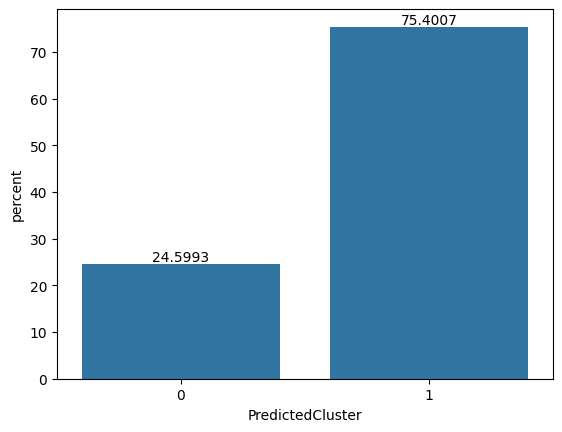

In [66]:
ax = sns.countplot(data=AlleleTable_MSI_oi, x='PredictedCluster', stat='percent')
ax.bar_label(container=ax.containers[0], )

<Axes: xlabel='diff', ylabel='Density'>

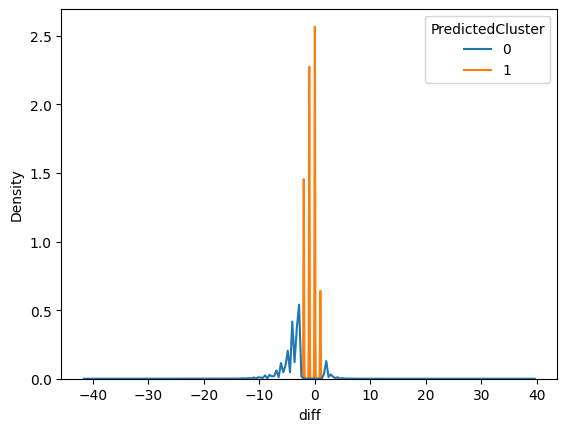

In [67]:
sns.kdeplot(data=AlleleTable_MSI_oi, x='diff', hue='PredictedCluster', common_norm=False,)